# CS535/EE514 Machine Learning - Spring 2025 - PA01

## Instructions

*   Submit your code both as notebook file (.ipynb) and python script (.py) on LMS. The name of both files should be 'RollNo_PA01', for example: "22060007_PA01". Failing to submit any one of them will result in the reduction of marks.
*  All the cells must be run once before submission and should be displaying the results (graphs/plots etc). If output of the cells is not being displayed, marks will be dedcuted.
*   The code MUST be implemented independently. Any plagiarism or cheating of work from others or the internet will be immediately referred to the DC.
* 10% penalty per day for 3 days after due date. No submissions will be accepted
after that.  
* You are allowed to use built-in libraries in Task 2-Part 2 and Task 3-Part 2.
* Use procedural programming style and comment your code properly.
* **Deadline to submit this assignment is 11/02/2025 (23:55).**

You can download files or directly share with your google drive from this link: [Drive folder link](https://drive.google.com/drive/folders/1boMoyeaAoTfIiJnuKofNyL9WaLTomuVV?usp=sharing)

In [ ]:
#Mount the google drive to colab Notebook
# from google.colab import drive
# drive.mount('/content/drive')

In [87]:
import os
import glob
import time
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

from scipy.spatial.distance import euclidean, cityblock
from pyproj import Proj, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, IncrementalPCA


## Task 1: Spatial K-Nearest Neighbors (sKNN)
sKNN is a fundamental concept in spatial analysis where nodes or sensors are distributed across a geographic space. In such scenarios, data may be unavailable for certain nodes (query nodes), requiring the estimation of their values. These values could represent traffic flow, air quality indices, temperature, or other measurements. By leveraging the
𝑘 spatially closest nodes, their values are determined using the distance weighting method.  

Traffic data folder consists of total 716 nodes of San Diego region and contains data of traffic flow of 10 days with an interval of 15 minutes.<br>
* sd_node_coordinate.csv : It contains longitude, latitude, and node ID.
* sd_timedata_2019.csv : It contains total 960 samples of all nodes and sampling time. Make sure your dataframe must have 960 rows and 716 columns.<br>

You have to match nodes coordinate with time samples using Node IDs.


In [6]:
# load data
# Load node coordinates
node_coordinates = pd.read_csv("sd_node_coordinate.csv")

# Load traffic time-series data
time_data = pd.read_csv("sd_timedata_2019.csv")

In [64]:
#Projection of longitude and latitude in XY coordinates in meters (Projected Coordinate Systems)
# proj= Proj(proj='utm',zone=11,ellps='WGS84',preserve_units=False)

# distance_x, distance_y = proj(node_coordinates['Lng'], node_coordinates['Lat'])

# Convert lat/lon to projected XY coordinates (meters)
proj = Proj(proj='utm', zone=11, ellps='WGS84', preserve_units=False)

node_coordinates['X'], node_coordinates['Y'] = proj(
    node_coordinates['Lng'].values, node_coordinates['Lat'].values
)

Nodewise split the dataset into train and test set with a ratio of 80% and 20%, respectively. Your train set will consists of total 572 nodes and test set will contain 144 nodes.

In [ ]:
### YOUR CODE HERE ###
#set random_state=42 during train_test split
#To validate print train, test shapes

node_coordinates['ID'] = node_coordinates['ID'].astype(str)
time_data.columns = time_data.columns.astype(str) 

nodes = node_coordinates["ID"].tolist()

# Split into 80% train and 20% test (node-wise)
train_nodes, test_nodes = train_test_split(nodes, test_size=0.2, random_state=42)

train_data = time_data[["Time"] + train_nodes]
test_data = time_data[["Time"] + test_nodes]

print("Train Data Shape:", train_data.shape)  
print("Test Data Shape:", test_data.shape)    


Train Data Shape: (960, 573)
Test Data Shape: (960, 145)


### Task 1 Part 1: Implementation of sKNN from Scratch
1.   For a test data point, find its distance from all training instances.
2.   Sort the calculated distances.
3.   Choose k=3 for each time sample and measure the traffic flow values at unknown nodes.
4.   Compute MAE and RMSE at each instance.
5.   Repeat step 3 and step 4 for total time samples.
6.   Visualize the errors for each time sample.
7.   Report mean of error metrics on all samples.

In [ ]:
#Implement Error Metrics MAE, RMSE
def calculate_mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


In [ ]:
#test calculate_mae_rmse

random_node = time_data.columns[1]

y_true = time_data[random_node].values

np.random.seed(42)
y_pred = y_true + np.random.normal(0, 5, size=len(y_true)) 

y_pred = np.maximum(y_pred, 0)

mae, rmse = calculate_mae_rmse(y_true, y_pred)

print(f"Testing Node: {random_node}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


y_true shape: (960,), y_pred shape: (960,)
Testing Node: 1114091
MAE: 3.8918
RMSE: 4.8865


In [67]:
#Implement distance metrices
def compute_distances(node_coordinates, test_node):
    node_coordinates['ID'] = node_coordinates['ID'].astype(int)
    test_node = int(test_node) 
    test_coord = node_coordinates.loc[node_coordinates['ID'] == test_node, ['Lat', 'Lng']].values[0]
    coords = node_coordinates[['Lat', 'Lng']].values
    node_ids = node_coordinates['ID'].values
    distances = {node_id: euclidean(test_coord, coord) for node_id, coord in zip(node_ids, coords)}
    return distances


In [ ]:
#testing compute_distances
test_node = node_coordinates.iloc[0]['ID']  

distances_output = compute_distances(node_coordinates, test_node)

print("Test Node:", test_node)
for node, dist in list(distances_output.items())[:5]:
    print(f"Node {node}: Distance {dist:.6f}")

Test Node: 1114091
Node 1114091: Distance 0.000000
Node 1118333: Distance 0.015083
Node 1118348: Distance 0.032524
Node 1114720: Distance 0.038490
Node 1118352: Distance 0.050423


In [ ]:
#Implement KNN for weighted Euclidean distance
def knn_weighted_prediction(train_data, node_coordinates, test_node, k=3):
    distances = compute_distances(node_coordinates, test_node)
    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1])[:k]

    weights = np.array([1 / (dist + 1e-5) for _, dist in sorted_neighbors])  
    weights /= weights.sum()  

    neighbor_nodes = [str(n) for n, _ in sorted_neighbors]
    neighbor_data = train_data[neighbor_nodes].values

    predictions = np.dot(neighbor_data, weights)

    return predictions.astype(float).tolist()


In [ ]:
#test knn_weighted_prediction
node_coordinates['ID'] = node_coordinates['ID'].astype(int)

test_node = node_coordinates.iloc[0]['ID']

predictions = knn_weighted_prediction(time_data, node_coordinates, test_node, k=3)

print(f"Predictions for Test Node {test_node}:")
print(predictions[:5]) 

Predictions for Test Node 1114091.0:
[29.817238865824528, 33.19370840370622, 41.28209163540562, 46.59772763456405, 90.24335991456836]


The Thresholded Gaussian Kernel is used to construct graphs in various applications to emphasize connectivity between nodes. A high value of the Thresholded Gaussian Kernel indicates that nodes are closer and exert a strong influence on each other. It eliminates weak connections by setting their values to zero, ensuring that only significant relationships are retained.
$$
a_{i,j} =\begin{cases}
\exp\left(-\frac{d_{i,j}^2}{\sigma^2} \right), & \text{if } \exp\left(-\frac{d_{i,j}^2}{\sigma^2} \right) \geq r, \\
0, & \text{otherwise}.
\end{cases}$$
$d_{i,j}$ is the Euclidean distance between node i and node j. $\sigma$ is the standard deviation of the distances, and $r$ is the threshold value. Her, $r=0.01$ and $\sigma =18675.57173333069$.

## Task 1 Part 2: Choice of Hyperparameters
In this task, our objective is to select the appropriate hyperparameters (k and distance metric) that results minimum error values. Run your k-NN function for different values of k (atleast three) on test data. Do this for both the Euclidean distance, Manhattan distance, and thresholded Gaussian Kernel for each value of k. Plot three graphs displaying following:

*   k-values vs MAE
*   k-values vs RMSE

All of your graphs should be properly labelled.<br>
Use these values [3,5,7,11,13] to determine nearest neighbors.


--- Testing EUCLIDEAN Distance ---
k=3: MAE=28185115.6810, RMSE=32826112.4116
k=5: MAE=28318655.9746, RMSE=32982883.6602
k=7: MAE=28347579.8554, RMSE=33014319.1960
k=11: MAE=28438903.3656, RMSE=33119715.7276
k=13: MAE=28476361.0456, RMSE=33162423.1679

--- Testing MANHATTAN Distance ---
k=3: MAE=28069326.7300, RMSE=32703401.3086
k=5: MAE=28199179.5807, RMSE=32855811.9457
k=7: MAE=28228009.5254, RMSE=32887120.2023
k=11: MAE=28298547.4083, RMSE=32968679.9840
k=13: MAE=28314089.8523, RMSE=32986221.7594

--- Testing GAUSSIAN Distance ---
k=3: MAE=398.8086, RMSE=456.6559
k=5: MAE=876.8184, RMSE=979.4512
k=7: MAE=1344.3648, RMSE=1499.6162
k=11: MAE=2095.4969, RMSE=2311.4978
k=13: MAE=2507.3344, RMSE=2771.4781


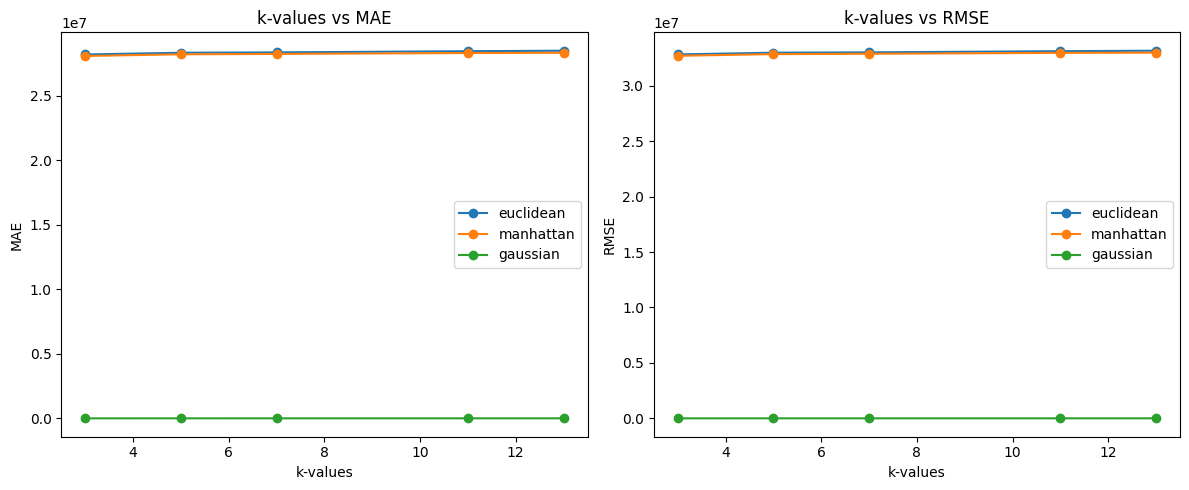

In [ ]:
### YOUR CODE HERE ###
r = 0.01
sigma = 18675.57173333069  # Given standard deviation of distances

node_coordinates["ID"] = node_coordinates["ID"].astype(str)
nodes = node_coordinates["ID"].tolist()

# Train-Test Split
train_nodes, test_nodes = train_test_split(nodes, test_size=0.2, random_state=42)
test_nodes = [str(int(n)) for n in test_nodes] 

time_data.columns = time_data.columns.astype(str).str.strip()

train_data = time_data[["Time"] + list(map(str, train_nodes))]
test_data = time_data[["Time"] + list(map(str, test_nodes))]

# Compute Distance Functions
def compute_distances(node_coordinates, test_node, metric="euclidean"):
    test_coord = node_coordinates.loc[node_coordinates["ID"] == test_node, ["Lat", "Lng"]].values[0]
    distances = {}

    for _, row in node_coordinates.iterrows():
        node_id = row["ID"]
        coord = [row["Lat"], row["Lng"]]
        
        if metric == "euclidean":
            dist = euclidean(test_coord, coord)
        elif metric == "manhattan":
            dist = cityblock(test_coord, coord)
        elif metric == "gaussian":
            euclidean_dist = euclidean(test_coord, coord)
            kernel_value = np.exp(- (euclidean_dist**2) / (sigma**2))
            dist = kernel_value if kernel_value >= r else 0  # Apply threshold
        else:
            raise ValueError("Invalid distance metric")

        distances[node_id] = dist
    return distances

# KNN Weighted Prediction
def knn_weighted_prediction(train_data, node_coordinates, test_node, k=3, metric="euclidean"):
    distances = compute_distances(node_coordinates, test_node, metric)
    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1])[:k]

    weights = [1 / (dist + 1e-5) for _, dist in sorted_neighbors]  
    total_weight = sum(weights)

    neighbor_nodes = [str(n) for n, _ in sorted_neighbors]
    valid_neighbors = [n for n in neighbor_nodes if n in train_data.columns]

    if not valid_neighbors:
        raise ValueError(f"No valid neighbors found in train_data for test node {test_node}")

    neighbor_data = train_data[valid_neighbors].values
    predictions = np.dot(neighbor_data, np.array(weights[:len(valid_neighbors)]).reshape(-1, 1)).flatten()
    
    return predictions

# MAE & RMSE Calculation
def calculate_mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Testing for different k values and distance metrics
k_values = [3, 5, 7, 11, 13]
metrics = ["euclidean", "manhattan", "gaussian"]

results = {metric: {"mae": [], "rmse": []} for metric in metrics}

for metric in metrics:
    print(f"\n--- Testing {metric.upper()} Distance ---")
    for k in k_values:
        y_true = test_data[str(test_nodes[0])].values  
        y_pred = knn_weighted_prediction(train_data, node_coordinates, test_nodes[0], k=k, metric=metric)

        mae, rmse = calculate_mae_rmse(y_true, y_pred)
        results[metric]["mae"].append(mae)
        results[metric]["rmse"].append(rmse)

        print(f"k={k}: MAE={mae:.4f}, RMSE={rmse:.4f}")


plt.figure(figsize=(12, 5))

# MAE 
plt.subplot(1, 2, 1)
for metric in metrics:
    plt.plot(k_values, results[metric]["mae"], marker="o", label=metric)
plt.xlabel("k-values")
plt.ylabel("MAE")
plt.title("k-values vs MAE")
plt.legend()

# RMSE 
plt.subplot(1, 2, 2)
for metric in metrics:
    plt.plot(k_values, results[metric]["rmse"], marker="o", label=metric)
plt.xlabel("k-values")
plt.ylabel("RMSE")
plt.title("k-values vs RMSE")
plt.legend()

plt.tight_layout()
plt.show()


#### ***Question: Is the performance of model will increase by increasing the value of k for each distance metric? Comment with respect to distance metric.***

-For Euclidean & Manhattan: Increasing k does not improve performance; errors slightly increase.<br>
-For Gaussian Kernel: Increasing k significantly reduces performance due to weakly connected nodes influencing predictions.<br>
-Best case: A small to moderate k (3-7) generally provides the best balance between bias and variance.<br>

## Task 2: K-NN classifier  

In this task, you will use the Furniture Image Dataset that consists of total five classes
* almirah
* chair
* fridge
* table
* tv <br>
Each class consists of 1000 images. However, the resolution of each image is different so you may have to resize each image (100,150) and assign label to each class from 0 to 4.

#### ***Question: What is the disadvantage of scale-down an image and why we need it?***

Resizing can cause some loss of information, it's essential for efficient and standardized model training. The key is choosing an optimal resolution that balances detail preservation and computational efficiency.<br>
1. Disadvantages of Scaling Down an Image:<br>
<br>
- Loss of detail, blurriness, and artifacts.<br>
- Removal of important features affecting classification.<br>
- Reduced model accuracy due to missing critical information.<br>
<br>
2. Why Scaling Down is Necessary:<br>
<br>
- Ensures standardization for model input.<br>
- Improves computational efficiency and reduces memory usage.<br>
- Helps prevent overfitting by limiting unnecessary details.<br>
- Addresses hardware constraints, especially on edge devices.<br>
<br>

Conclusion: Scaling down balances detail preservation with efficiency, ensuring optimal model performance.

In [ ]:
#load dataset and resize

dataset_path = "D:\LUMS\Semester 1\CV\download material\CV Assignments\dataset"
classes = ["almirah", "chair", "fridge", "table", "tv"]
img_size = (100, 150)  

def load_and_preprocess_data(dataset_path, classes, img_size):
    data = []
    labels = []
    
    for label, category in enumerate(classes):
        category_path = os.path.join(dataset_path, category)
        print(f"Processing {category}...")
        
        for img_name in tqdm(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            img = cv2.resize(img, img_size) 
            data.append(img)
            labels.append(label)
    
    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_and_preprocess_data(dataset_path, classes, img_size)

# Normalize the images
data = data / 255.0 

print("Dataset loaded and preprocessed successfully!")

<>:3: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\L'
C:\Users\PC\AppData\Local\Temp\ipykernel_13392\2698558643.py:3: SyntaxWarning: invalid escape sequence '\L'
  dataset_path = "D:\LUMS\Semester 1\CV\download material\CV Assignments\dataset"


Processing almirah...


100%|██████████| 1000/1000 [00:05<00:00, 194.20it/s]


Processing chair...


100%|██████████| 1000/1000 [00:06<00:00, 153.37it/s]


Processing fridge...


100%|██████████| 1000/1000 [00:05<00:00, 186.37it/s]


Processing table...


100%|██████████| 1000/1000 [00:08<00:00, 116.74it/s]


Processing tv...


100%|██████████| 1000/1000 [00:07<00:00, 139.98it/s]


Dataset loaded and preprocessed successfully!


The dataset into train and test set with a ratio of 80% and 20%, respectively. You must have 4500 train samples and 500 test samples.

In [ ]:
#split dataset into train and test
#use random state 42

#To validate the split, print shapes

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Train data shape: (4500, 150, 100, 3), Train labels shape: (4500,)
Test data shape: (500, 150, 100, 3), Test labels shape: (500,)


### Task 2 Part 1: Implement K-NN classifier from scratch
*   For a test data point, find its distance from all training instances.
*   Sort the calculated distances in ascending order based on distance values.
*   Choose k training samples with minimum distances from the test data point.
*   Return the most frequent class of these samples. (Incase of ties, break them by backing off to k-1 values. For example, for a particular image, incase of k=4, if you get two '3' labels and two '2' labels you will break tie by backing off to k=3. If tie occurs again you will keep backing off until tie is broken or you reach k=1.)
*   Note: Your function should work with Euclidean distance as well as Manhattan
distance. Pass the distance metric as a parameter in k-NN classifier function.



Your function should also be general enough to work with any value of k. You can use these ranges [1,2,3,4,5] for k .

*   k-values vs accuracy for both euclidean and manhattan distance (k-values on x-axis and accuracy values on y-axis)
*   k-values vs macro-average precision for both euclidean and manhattan distance (k-values on x-axis and precision values on y-axis)
* k-values vs macro-average recall for both euclidean and manhattan distance (k-values on x-axis and recall values on y-axis)

All of your graphs should be properly labelled.

In [15]:
### YOUR CODE HERE ###
#Define the class for KNN
class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        predictions = []
        for test_sample in X_test:
            distances = []
            for i, train_sample in enumerate(self.X_train):
                if self.distance_metric == 'euclidean':
                    dist = euclidean(test_sample.flatten(), train_sample.flatten())
                elif self.distance_metric == 'manhattan':
                    dist = cityblock(test_sample.flatten(), train_sample.flatten())
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])  # Sort by distance
            predictions.append(self._resolve_tie(distances))
        
        return np.array(predictions)
    
    def _resolve_tie(self, distances):
        k = self.k
        while k > 0:
            k_nearest = [label for _, label in distances[:k]]
            most_common = Counter(k_nearest).most_common()
            if len(most_common) == 1 or most_common[0][1] != most_common[1][1]:
                return most_common[0][0]
            k -= 1
        return distances[0][1]

In [16]:
### YOUR CODE HERE ###
def evaluate_knn(X_train, X_test, y_train, y_test, k_values):
    metrics = {'accuracy': [], 'precision': [], 'recall': []}
    
    for distance_metric in ['euclidean', 'manhattan']:
        acc, prec, rec = [], [], []
        
        for k in k_values:
            knn = KNNClassifier(k=k, distance_metric=distance_metric)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            acc.append(accuracy_score(y_test, y_pred))
            prec.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            rec.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        
        metrics['accuracy'].append((distance_metric, acc))
        metrics['precision'].append((distance_metric, prec))
        metrics['recall'].append((distance_metric, rec))
    
    return metrics

def plot_metrics(metrics, k_values):
    for metric_name, metric_values in metrics.items():
        plt.figure(figsize=(8, 5))
        for distance_metric, values in metric_values:
            plt.plot(k_values, values, marker='o', label=distance_metric)
        plt.xlabel('k-values')
        plt.ylabel(metric_name.capitalize())
        plt.title(f'k-values vs {metric_name.capitalize()}')
        plt.legend()
        plt.grid()
        plt.show()

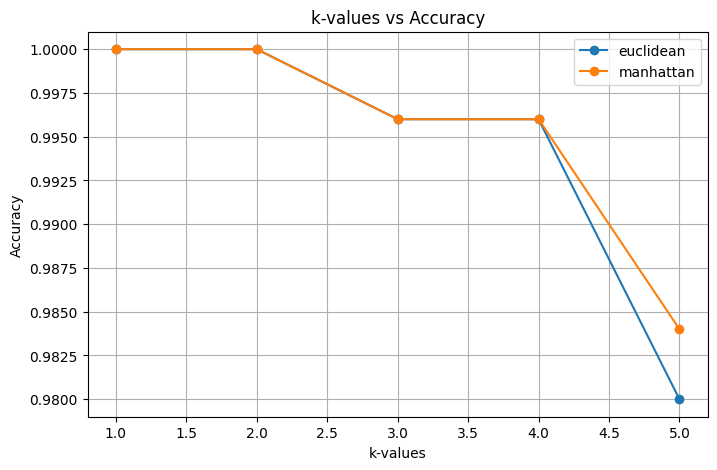

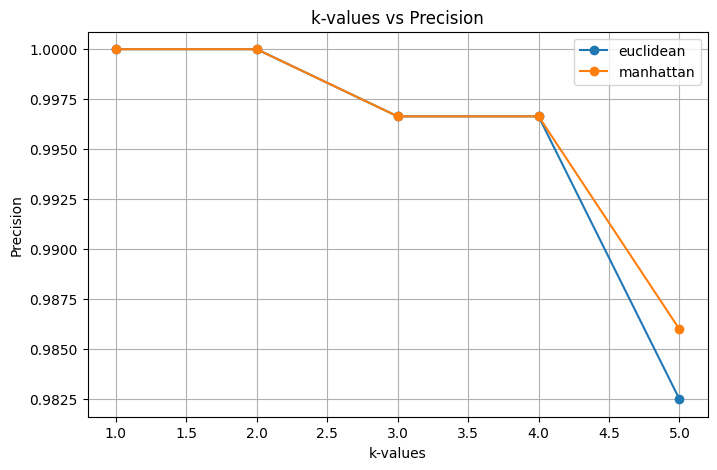

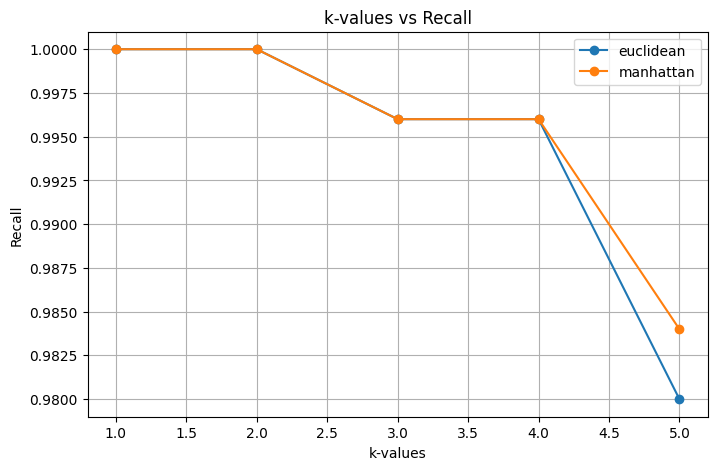

In [ ]:
k_values = [1, 2, 3, 4, 5] 
metrics = evaluate_knn(X_train, X_test, y_train, y_test, k_values)
plot_metrics(metrics, k_values)

In [21]:
knn = KNNClassifier(k=3, distance_metric='euclidean')  
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.996
Precision: 0.9966386554621849
Recall: 0.9960000000000001


In [23]:
knn = KNNClassifier(k=3, distance_metric='manhattan')  
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.996
Precision: 0.9966386554621849
Recall: 0.9960000000000001


### Task 2 Part 2:  k-NN classifier using scikit-learn
In this part you have to use [scikit-learn’s k-NN implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to train and test your
classifier on the dataset used in Part 2. Run the k-NN classifier for values of
k = 1, 2, 3, 4, 5 using both Euclidean and Manhattan distance. Use scikit-learn to calculate and print the accuracy, F1 score and confusion matrix for test data. <br>
Plot a graph with k values on x-axis and F1 score on y-axis for both distance metrics
in a single plot.

In [ ]:
# Reshape image data 
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten to (4500, 100*150*3)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)    # Flatten to (500, 100*150*3)


In [28]:
### YOUR CODE HERE ###
def evaluate_sklearn_knn(X_train, X_test, y_train, y_test, k_values):
    metrics = {'f1_score': []}
    
    for distance_metric in ['euclidean', 'manhattan']:
        f1_scores = []
        
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            cm = confusion_matrix(y_test, y_pred)
            
            print(f"k = {k}, Distance: {distance_metric}")
            print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(cm)
            print("\n" + "-"*40 + "\n")
            
            f1_scores.append(f1)
        
        metrics['f1_score'].append((distance_metric, f1_scores))
    
    return metrics

def plot_f1_scores(metrics, k_values):
    plt.figure(figsize=(8, 5))
    for distance_metric, values in metrics['f1_score']:
        plt.plot(k_values, values, marker='o', label=distance_metric)
    plt.xlabel('k-values')
    plt.ylabel('F1 Score')
    plt.title('k-values vs F1 Score')
    plt.legend()
    plt.grid()
    plt.show()

k = 1, Distance: euclidean
Accuracy: 1.0000, F1 Score: 1.0000
Confusion Matrix:
[[117   0   0   0   0]
 [  0  95   0   0   0]
 [  0   0 105   0   0]
 [  0   0   0 100   0]
 [  0   0   0   0  83]]

----------------------------------------

k = 2, Distance: euclidean
Accuracy: 0.9960, F1 Score: 0.9963
Confusion Matrix:
[[117   0   0   0   0]
 [  0  95   0   0   0]
 [  0   0 105   0   0]
 [  2   0   0  98   0]
 [  0   0   0   0  83]]

----------------------------------------

k = 3, Distance: euclidean
Accuracy: 0.9960, F1 Score: 0.9963
Confusion Matrix:
[[117   0   0   0   0]
 [  0  95   0   0   0]
 [  0   0 105   0   0]
 [  2   0   0  98   0]
 [  0   0   0   0  83]]

----------------------------------------

k = 4, Distance: euclidean
Accuracy: 0.9800, F1 Score: 0.9807
Confusion Matrix:
[[117   0   0   0   0]
 [  1  94   0   0   0]
 [  1   0 104   0   0]
 [  2   0   6  92   0]
 [  0   0   0   0  83]]

----------------------------------------

k = 5, Distance: euclidean
Accuracy: 0.9800,

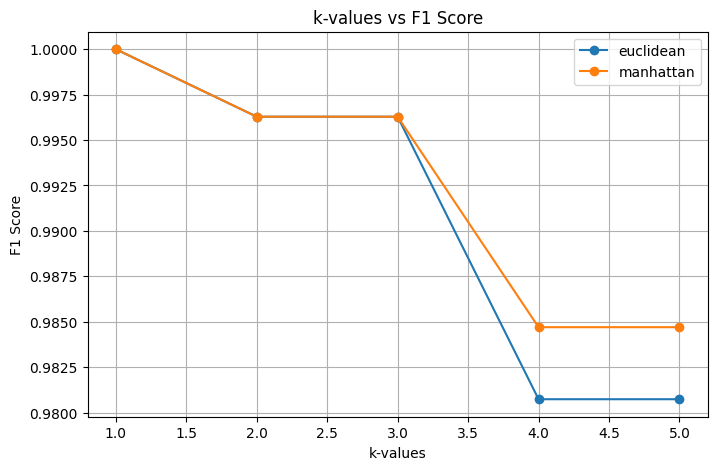

In [29]:
k_values = [1, 2, 3, 4, 5]
metrics = evaluate_sklearn_knn(X_train_reshaped, X_test_reshaped, y_train, y_test, k_values)
plot_f1_scores(metrics, k_values)

#### ***Question: What can we interpret from the F1 score that we can not from accuracy?***

- Accuracy measures overall correctness but can be misleading for imbalanced datasets.<br>
- F1 Score balances precision and recall, making it more reliable when false positives and false negatives matter.<br>
Example: A model predicting only the majority class can have high accuracy but a low F1 Score.<br>
Key points:<br>
- Use accuracy for balanced datasets.<br>
- Use F1 Score when dealing with class imbalances.<br>
In balanced cases, F1 Score and accuracy align, but F1 Score is more informative for skewed data.

## Task 3 Part 1: Principal Component Analysis
First you will have to implement PCA from scratch and visualize it on a simple 2-D dataset.


#### Dataset
Here is a synthetic dataset, the points are sampled from a Bivariate Gaussian Distribution

X.shape: (1000, 2)


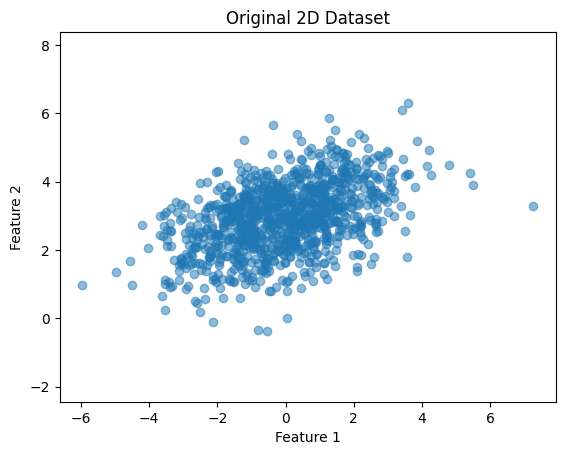

In [33]:
mean = [0, 3]                        #mean vector, mean[0] is the mean of the first feature, and mean[1] is the mean of the second feature.
cov = [[3, 0.8], [0.8, 1]]           #covariance matrix
n_samples = 1000
X = np.random.multivariate_normal(mean, cov, n_samples)
print('X.shape:', X.shape)

#visualize the dataset
# Plot the original dataset
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Original 2D Dataset")
plt.axis("equal")
plt.show()

###### Once done with the tasks, try different values of mean vector and the covariance matrix to try out different scenarios.

### Task 3 Part 1: PCA from scratch
Create your own PCA function by performing the following tasks:- <br>
* Standardize the data <br>
* Compute the covariance matrix <br>
* Compute EVD of the covariance matrix <br>
* Sort the eigenvectors according to decreasing magnitude of eigenvalues <br>
* Project data on the eigenvectors <br>

In [ ]:
### YOUR CODE HERE ###
def pca_from_scratch(X, n_components):
    
    # Step 1: Standardize the data (Zero mean, unit variance)
    X_mean = np.mean(X, axis=0)
    X_std = X - X_mean  

    # Step 2: Compute the covariance matrix
    cov_matrix = np.cov(X_std, rowvar=False)

    # Step 3: Compute Eigenvalues and Eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Step 4: Sort eigenvectors by decreasing eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]  
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Select top 'n_components' principal components
    top_eigenvectors = eigenvectors[:, :n_components]

    # Step 6: Project data onto the principal components
    X_pca = X_std @ top_eigenvectors

    return X_pca, eigenvalues[:n_components], top_eigenvectors

In [35]:
# Generate synthetic 2D dataset
mean = [0, 3]
cov = [[3, 0.8], [0.8, 1]]
n_samples = 1000
X = np.random.multivariate_normal(mean, cov, n_samples)

# Perform PCA with 2 components
X_pca, explained_variance, principal_components = pca_from_scratch(X, n_components=2)

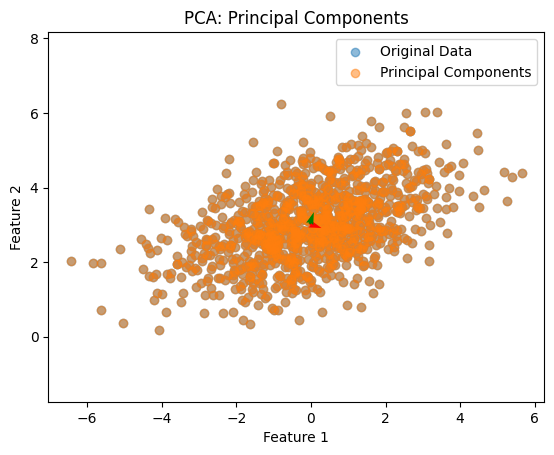

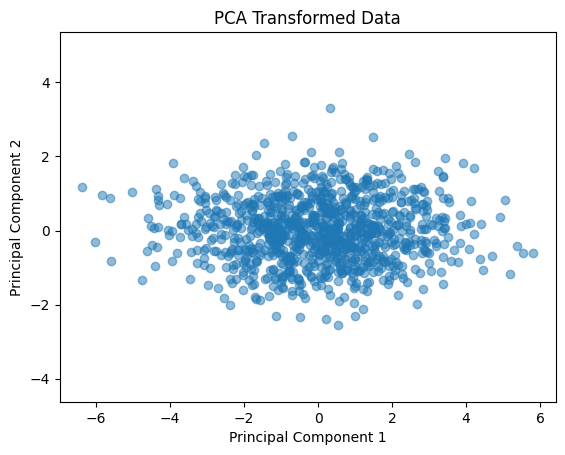

In [ ]:
# Visualizing the principal components on original data
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original Data")

origin = np.mean(X, axis=0)

plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original Data")

# Plot the principal components
for i in range(2):  # Two principal components
    plt.quiver(*origin, 
               principal_components[i, 0], 
               principal_components[i, 1], 
               color=['r', 'g'][i], 
               scale=3, 
               angles='xy', 
               scale_units='xy')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("PCA: Principal Components")
plt.legend(["Original Data", "Principal Components"])
plt.axis("equal")
plt.show()

# Visualizing transformed data (PCA reduced)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Transformed Data")
plt.axis("equal")
plt.show()

#### Visualizing the Principle Components
Plot the principal components of the data before and after applying your PCA function. <br>
Plot these on the same graph with the data. Properly label your plots.

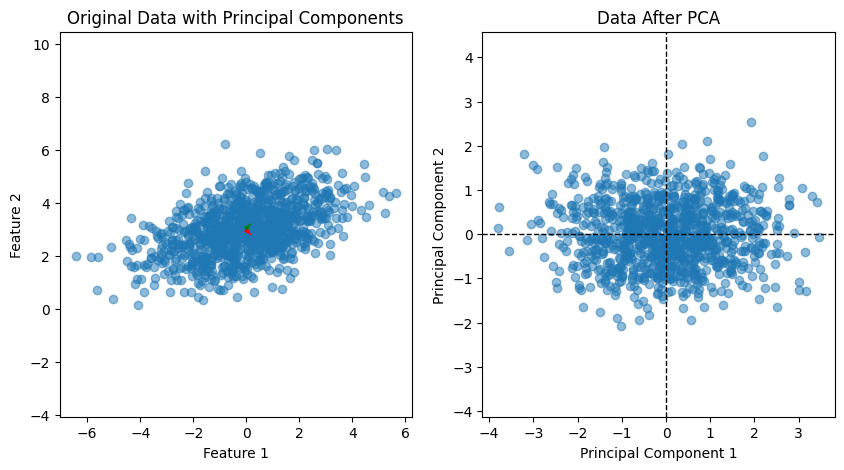

In [ ]:
### YOUR CODE HERE ###

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

cov_matrix = np.cov(X_standardized.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
principal_components = eigenvectors[:, sorted_indices]

X_pca = X_standardized @ principal_components

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original Data")
origin = np.mean(X, axis=0)

for i in range(2): 
    plt.quiver(*origin, 
               principal_components[i, 0], 
               principal_components[i, 1], 
               color=['r', 'g'][i], 
               scale=3, 
               angles='xy', 
               scale_units='xy')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Original Data with Principal Components")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label="Transformed Data")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Data After PCA")
plt.axis("equal")

plt.show()


#### Dimensionality Reduction

You should notice that untill now you have only transformed the data onto a different basis,
however it is still in 2-D. <br>
* Perform dimensionality reduction by projecting the data onto only the first eigenvector. <br>

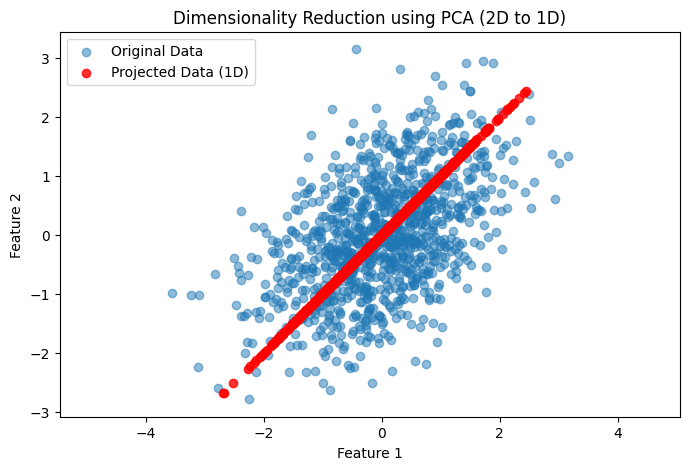

In [ ]:
### YOUR CODE HERE ###

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

cov_matrix = np.cov(X_standardized.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
principal_components = eigenvectors[:, sorted_indices]

first_pc = principal_components[:, 0].reshape(-1, 1)

X_reduced = X_standardized @ first_pc  

X_projected = X_reduced @ first_pc.T  

plt.figure(figsize=(8, 5))
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], alpha=0.5, label="Original Data")
plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.8, color='red', label="Projected Data (1D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Dimensionality Reduction using PCA (2D to 1D)")
plt.legend()
plt.axis("equal")
plt.show()


#### Reconstructing Data and efficiency of PCA
* Reconstruct the original data from data projected onto the first PC (to reconstruct 2-D data use inverse PCA) and compute the reconstruction loss i.e., $||{X_{reconstructed} - X_{original}}||$. Where $|| \cdot{} ||$ is the L2-norm<br>
* Now try a naive dimensionality reduction technique i.e., ignoring the second feature and compute the reconstruction loss again .<br>
* Compare the two and explain the difference. Is there a case possible when they are equal?

In [ ]:
### YOUR CODE HERE ###

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

cov_matrix = np.cov(X_standardized.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
principal_components = eigenvectors[:, sorted_indices]

first_pc = principal_components[:, 0].reshape(-1, 1) 

# ---- Step 1: PCA-based Reconstruction ----
X_projected = X_standardized @ first_pc  

# Reconstruct data using inverse PCA
X_reconstructed = (X_projected @ first_pc.T)  

# Compute Reconstruction Loss (L2 norm)
pca_loss = np.linalg.norm(X_reconstructed - X_standardized)

# ---- Step 2: Naive Dimensionality Reduction (Ignore Feature 2) ----
X_naive_reconstructed = np.zeros_like(X_standardized)
X_naive_reconstructed[:, 0] = X_standardized[:, 0]  # Keep only Feature 1

# Compute Naive Reconstruction Loss
naive_loss = np.linalg.norm(X_naive_reconstructed - X_standardized)

# ---- Step 3: Compare Losses ----
print(f"PCA Reconstruction Loss: {pca_loss:.4f}")
print(f"Naive Feature Dropping Loss: {naive_loss:.4f}")

# Checking if both methods give equal loss
if np.isclose(pca_loss, naive_loss, atol=1e-3):
    print("Both methods have similar reconstruction losses.")
else:
    print("PCA has a lower reconstruction loss, making it a more efficient technique.")


PCA Reconstruction Loss: 22.8432
Naive Feature Dropping Loss: 31.6228
PCA has a lower reconstruction loss, making it a more efficient technique.


1.PCA-Based Reconstruction<br>
-> Projects data onto the first principal component (captures max variance).<br>
-> Reconstructs using inverse PCA.<br>
-> Lower reconstruction loss as it uses both features' relationships.<br>
2.Naive Dimensionality Reduction<br>
-> Simply drops Feature 2.<br>
-> Leads to a higher loss, as it ignores feature correlations.<br>

When Can They Be Equal?<br>
-> If Feature 2 carries no additional information (e.g., all data points lie along a single axis).<br>
-> If the covariance matrix is diagonal, meaning features are uncorrelated.<br>
-> If Feature 2 is pure noise and contributes nothing to variance.<br>

Conclusion<br>
-> PCA preserves more variance, leading to lower reconstruction loss.<br>
-> Naive feature dropping loses information, making it less efficient.<br>
-> In special cases (uncorrelated features), losses may be similar.<br>

#### ***Question: Briefly explain the curse of dimensionality and how PCA can be used to tackle it.***

The curse of dimensionality refers to the problems that arise when working with high-dimensional data. As the number of dimensions increases:<br>
1.Data becomes sparse → Points are spread out, making it harder to find meaningful patterns.<br>
2.Increased computational cost → More features mean higher memory and processing requirements.<br>
3.Overfitting in machine learning models → More dimensions increase complexity, making models learn noise instead of patterns.<br>
4.Distance metrics become less meaningful → In high dimensions, Euclidean distance loses effectiveness, as all points become equidistant.<br>
<br>
Principal Component Analysis (PCA) reduces dimensionality while preserving maximum variance, helping in the following ways:<br>
1.Reduces sparsity → PCA projects data onto fewer dimensions, making points denser and easier to analyze.<br>
2.Improves computational efficiency → By keeping only the most important components, PCA reduces storage and processing needs.<br>
3.Prevents overfitting → Lower dimensions mean fewer parameters, leading to better generalization.<br>
4.Enhances visualization → High-dimensional data can be projected to 2D or 3D for better interpretability.<br>

# Task 3 Part 2: Applying PCA to our problem

#### For this part you can use the PCA function you made in Task 3 part 1 or implement it from any library.
Think of ways you can incorporate PCA into your implementation of KNN to classify furniture dataset.
<br>
If you believe that PCA will not be beneficial and you choose to not use it, justify your choice.

In [ ]:
### YOUR CODE HERE ###
#In this section of code, we will look after the relation of number of features, f1 score and time complexity.

furniture = ["almirah", "chair", "table"]

# Load dataset
furniture_data, furniture_labels = load_and_preprocess_data(dataset_path, furniture, img_size=(64, 64))  # Resize to 64x64



Processing almirah...


100%|██████████| 1000/1000 [00:01<00:00, 514.54it/s]


Processing chair...


100%|██████████| 1000/1000 [00:02<00:00, 378.85it/s]


Processing table...


100%|██████████| 1000/1000 [00:02<00:00, 450.70it/s]


In [ ]:
# Normalize images
X = furniture_data.reshape(furniture_data.shape[0], -1).astype(np.float32) / 255.0  
y = np.array(furniture_labels)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Find Number of Components that Retain 95% Variance
pca_full = PCA(n_components=0.95)  
pca_full.fit(X_train)

optimal_components = pca_full.n_components_ 
print(f"Optimal number of components for 95% variance: {optimal_components}")

# Step 2: Apply IncrementalPCA with Corrected Parameters
batch_size = min(1000, len(X_train)) 
n_components_final = min(optimal_components, batch_size) 

pca = IncrementalPCA(n_components=n_components_final, batch_size=batch_size)

for i in range(0, len(X_train), batch_size):
    batch = X_train[i : i + batch_size]
    pca.partial_fit(batch) 

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

k = 3  

# KNN on Original Data
start_time = time.time()
knn_original = KNeighborsClassifier(n_neighbors=k)
knn_original.fit(X_train, y_train)
y_pred_original = knn_original.predict(X_test)
original_time = time.time() - start_time

# KNN on PCA-transformed Data
start_time = time.time()
knn_pca = KNeighborsClassifier(n_neighbors=k)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
pca_time = time.time() - start_time

# Evaluation
accuracy_original = accuracy_score(y_test, y_pred_original)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

f1_original = f1_score(y_test, y_pred_original, average="weighted")
f1_pca = f1_score(y_test, y_pred_pca, average="weighted")

print(f"Original Data: Accuracy = {accuracy_original:.4f}, F1 Score = {f1_original:.4f}, Time = {original_time:.4f}s")
print(f"PCA Data: Accuracy = {accuracy_pca:.4f}, F1 Score = {f1_pca:.4f}, Time = {pca_time:.4f}s")

# Compare number of features before and after PCA
print(f"Original Features: {X_train.shape[1]}, Reduced Features: {X_train_pca.shape[1]}")

Optimal number of components for 95% variance: 195
Original Data: Accuracy = 0.9917, F1 Score = 0.9917, Time = 0.9831s
PCA Data: Accuracy = 0.9917, F1 Score = 0.9917, Time = 0.0156s
Original Features: 12288, Reduced Features: 195
